Reference:

https://www.ncei.noaa.gov/products/world-ocean-atlas

https://www.ncei.noaa.gov/sites/default/files/2020-04/woa18documentation.pdf

Nearest interpolation from woa18 basin mask to fesom2 mesh.

In [1]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

import sys
sys.path.append('/home/ollie/psong/post_spy_fesom2/modules_pscholz')

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import *
from sub_regriding_adapt import *
from sub_fesom_plot import *
from sub_fesom_data_netcdf4 import *

In [2]:
def regular2fesom(data, lon, lat, mesh, how='idist', target='node', k=10, radius_of_influence=100000, n_jobs=2):
    '''
    should flatten lon/lat from regular mesh and remove nan points
    '''
    # nn or idist
    if how == 'nn': k=1
    
    # source and target (node or elem)
    if target == 'node':
        xt, yt, zt = lon_lat_to_cartesian(mesh.nodes_2d_xg, mesh.nodes_2d_yg)
    elif target == 'elem':
        xt, yt, zt = lon_lat_to_cartesian(mesh.nodes_2d_xg[mesh.elem_2d_i].sum(axis=1)/3, \
                                          mesh.nodes_2d_yg[mesh.elem_2d_i].sum(axis=1)/3 )
    
    xs, ys, zs = lon_lat_to_cartesian(lon, lat)
    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k = k, n_jobs=n_jobs)
    
    # interpolation
    if distances.ndim == 1:
        data_interpolated = data[inds]
    else:
        distances_ma = np.ma.masked_greater(distances, radius_of_influence)
        w = 1.0 / distances_ma**2
        data_interpolated = np.ma.sum(w * data[inds], axis=1) / np.ma.sum(w, axis=1)
    
    return data_interpolated

def plot_bmask_tri(ax,mesh,data,inputarray,cmap):
    #______________________________________________________________________
    m = Basemap(projection=inputarray['proj'], resolution='c', \
                llcrnrlon=inputarray['which_box'][0], urcrnrlon=inputarray['which_box'][1], \
                llcrnrlat=inputarray['which_box'][2], urcrnrlat=inputarray['which_box'][3], \
                area_thresh=10000, ax=ax, suppress_ticks=True)
    #______________________________________________________________________
    mx, my = m(mesh.nodes_2d_xg, mesh.nodes_2d_yg)
    tri = Triangulation(mx, my, mesh.elem_2d_i)
    mask_tri = TriAnalyzer(tri).get_flat_tri_mask(0.00001)
    hp = ax.tripcolor(tri,data,edgecolors='None',antialiased=False,shading='flat',cmap=cmap,vmin=0.5,vmax=12.5)
    #______________________________________________________________________________
    xlabels, ylabels = [0,0,0,1], [1,0,0,0]
    xticks, yticks = np.linspace(60,360,6), np.linspace(-60,60,5)
    m.drawmeridians(xticks,labels=xlabels,linewidth=0.25,dashes=[1,1e-10],fontsize=10)
    m.drawparallels(yticks,labels=ylabels,linewidth=0.25,dashes=[1,1e-10],fontsize=10)
    m.drawmapboundary(fill_color='0.8',linewidth=1.0)
    m.drawcoastlines(color='k',linewidth=0.5)
    m.fillcontinents(color='0.6')
    #______________________________________________________________________
    cbar = plt.colorbar(hp, ax=ax, shrink=0.8, drawedges=True, extend='neither', orientation='horizontal')
    cbar.set_ticks(range(1,13))
    
    return(ax,hp)

def plot_bmask(ax,lon,lat,data,inputarray,cmap):
    #______________________________________________________________________
    m = Basemap(projection=inputarray['proj'], resolution='c', \
                llcrnrlon=inputarray['which_box'][0], urcrnrlon=inputarray['which_box'][1], \
                llcrnrlat=inputarray['which_box'][2], urcrnrlat=inputarray['which_box'][3], \
                area_thresh=10000, ax=ax, suppress_ticks=True)
    #______________________________________________________________________
    LON, LAT = np.meshgrid(lon,lat)
    mx, my = m(LON, LAT)
    hp = ax.pcolor(mx,my,data,edgecolors='None',antialiased=False,cmap=cmap,vmin=0.5,vmax=12.5)
    #______________________________________________________________________________
    xlabels, ylabels = [0,0,0,1], [1,0,0,0]
    xticks, yticks = np.linspace(60,360,6), np.linspace(-60,60,5)
    m.drawmeridians(xticks,labels=xlabels,linewidth=0.25,dashes=[1,1e-10],fontsize=10)
    m.drawparallels(yticks,labels=ylabels,linewidth=0.25,dashes=[1,1e-10],fontsize=10)
    m.drawmapboundary(fill_color='0.8',linewidth=1.0)
    m.drawcoastlines(color='k',linewidth=0.5)
    m.fillcontinents(color='0.6')
    #______________________________________________________________________
    cbar = plt.colorbar(hp, ax=ax, shrink=0.8, drawedges=True, extend='neither', orientation='horizontal')
    cbar.set_ticks(range(1,13))
    
    return(ax,hp)

In [3]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM MESH ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['mesh_id'],inputarray['mesh_dir'] = 'COREv2', '/work/ollie/psong/meshes/fesom2_core2_meanz/'
    
# set plot box for cyl projection (default: [-180,180,-90,90])
inputarray['which_box'] = [30,390,-90,90]

# set projection variable --> the lon/lat projection plot ranges are set via 
inputarray['proj'     ] = 'cyl' # 'ortho', 'cyl', 'npstere' , 'spstere'

try:
	mesh
except NameError:
    mesh = fesom_init_mesh(inputarray)
else:
	print(" --> ___FOUND FESOM MESH --> will use it!___________________________") 

mesh.focus=210
mesh.fesom_grid_rot_r2g(str_mode='focus')
lon_start = inputarray['which_box'][0]


___LOAD FESOM MESH COREv2_________________________________________
 --> read grid files
     > nod2d.out  : #2dn=126858
     > elem2d.out : #2de=244659
     > aux3d.out
     > nlvls.out
     > elvls.out
 --> rotate mesh rot2geo
 --> remove cyclic boundary
_______________________________________________________________
 --> change mesh focus
 --> remove cyclic boundary


Usually use 0m basin mask code. Drop out some bad points whose codes are zero.

In [4]:
bmask_fname = 'https://www.ncei.noaa.gov/data/oceans/woa/WOA18/MASKS/basinmask_04.msk'
bmask = pa.read_csv(bmask_fname,skiprows=[0], index_col=False)

bmask_lon0 = bmask.Longitude.to_numpy()
bmask_lat0 = bmask.Latitude.to_numpy()
bmask_code0 = bmask.Basin_0m.to_numpy()

bmask_index = (bmask_code0!=0)

bmask_lon = bmask_lon0[bmask_index]
bmask_lat = bmask_lat0[bmask_index]
bmask_code = bmask_code0[bmask_index]

bmask_lon0[bmask_lon0<lon_start] = bmask_lon0[bmask_lon0<lon_start]+360.0
bmask_lon[bmask_lon<lon_start] = bmask_lon[bmask_lon<lon_start]+360.0

Don't worry about the plot, the tripcolor itself interpolate nodal points to triangular elems.

<IPython.core.display.Javascript object>


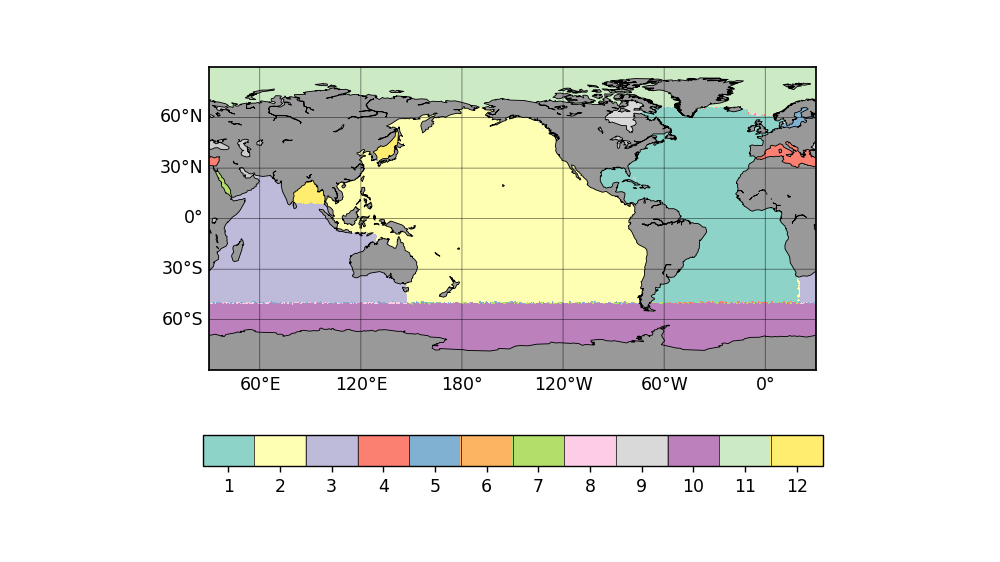

/home/ollie/psong/miniconda3/envs/psong_wind/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [5]:
fesom_bmaskn = regular2fesom(bmask_code, bmask_lon, bmask_lat, mesh, how='nn', target='node')

fig, ax = plt.subplots(1,1,figsize=(8,4.5))
ax, hp = plot_bmask_tri(ax,mesh,fesom_bmaskn,inputarray,cm.Set3)

This time looks good

<IPython.core.display.Javascript object>


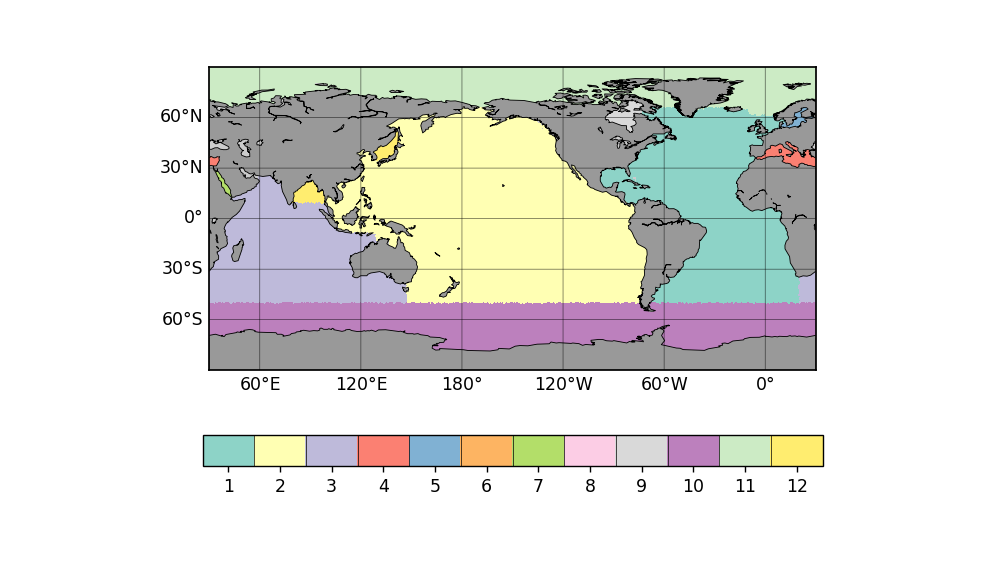

/home/ollie/psong/miniconda3/envs/psong_wind/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [6]:
fesom_bmaske = regular2fesom(bmask_code, bmask_lon, bmask_lat, mesh, how='nn', target='elem')

fig, ax = plt.subplots(1,1,figsize=(8,4.5))
ax, hp = plot_bmask_tri(ax,mesh,fesom_bmaske,inputarray,cm.Set3)

Read 3-d basin mask code. This part is quite slow. Just for checking.

In [7]:
var_fname = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/salinity/decav/0.25/woa18_decav_s00_04.nc'
var_ds = Dataset(var_fname)

var_lon = var_ds.variables['lon'][:].data
var_lat = var_ds.variables['lat'][:].data
var_dep = var_ds.variables['depth'][:].data

var_lon=np.concatenate((var_lon[var_lon>=lon_start],var_lon[var_lon<lon_start]),axis=0)
var_lon[var_lon<lon_start] = var_lon[var_lon<lon_start]+360.0

bmask_code3d = np.zeros((len(var_lon), len(var_lat), len(var_dep)))*np.nan
for i in range(len(bmask_lon0)):
    index_x = np.where(var_lon == bmask_lon0[i])
    index_y = np.where(var_lat == bmask_lat0[i])
    bmask_profile = bmask.iloc[i]
    for index_z in range(len(bmask_profile)-2):
        bmask_code3d[index_x, index_y, index_z] = bmask_profile[index_z+2]

The original basin mask code at ocean surface.

<IPython.core.display.Javascript object>


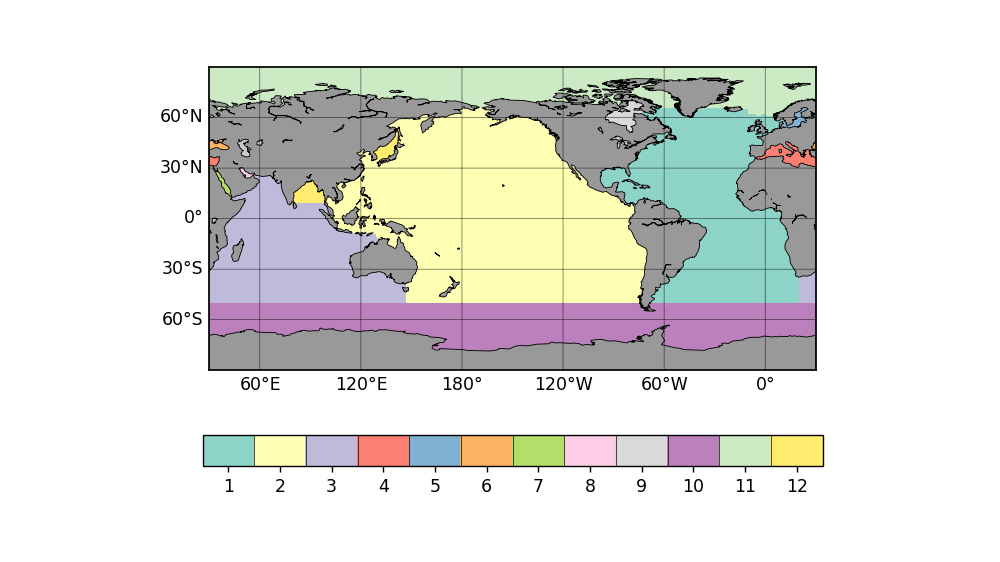

/home/ollie/psong/miniconda3/envs/psong_wind/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [8]:
bmask_surf = np.transpose(bmask_code3d[:,:,0])

fig, ax = plt.subplots(1,1,figsize=(8,4.5))
ax, hp = plot_bmask(ax,var_lon,var_lat,bmask_surf,inputarray,cm.Set3)